# Oceanstream - EK80 Example

### Setting up project root for module imports in Jupyter Notebook

In [1]:
# Import the os module to work with the file system
import os

# Get the absolute path of the current notebook.
# This assumes the notebook's name is "oceanstream_ek80_example.ipynb".
# Note: "oceanstream_ek80_example.ipynb" is located in the "notebooks" folder of the "oceanstream" repo.
# This folder is typically ignored to maintain a clear organization of the project.
notebook_path = os.path.abspath("oceanstream_ek80_example.ipynb")
notebooks_folder_path = os.path.abspath(os.path.join(notebook_path, os.pardir))

# Navigate up two directories from the notebook's path to get to the project root
project_root = os.path.abspath(os.path.join(notebook_path, os.pardir, os.pardir))

# Import the sys module to modify the Python path
import sys

# Append the project root to the Python path so that modules from the project can be imported
sys.path.append(project_root)

**Specifies the path to the test data utilized in this notebook:**

In [2]:
oceanstream_ek80_path =  os.path.join(notebooks_folder_path, "test_data", "oceanstream_ek80")

### Imports

In [3]:
import gc
import os
import urllib.request

import echopype.visualize as epviz
import fsspec
import matplotlib.pyplot as plt

from oceanstream.L0_unprocessed_data import raw_handler, ensure_time_continuity
from oceanstream.L2_calibrated_data import (
    sv_computation,
    sv_dataset_extension,
    noise_masks,
    sv_interpolation,
    processed_data_io
)
from oceanstream.L3_regridded_data import (
    applying_masks_handler,
    nasc_computation,
    frequency_differencing_handler,
    shoal_detection_handler
)
from oceanstream.L3_regridded_data.applying_masks_handler import apply_mask_organisms_in_order
from oceanstream.L3_regridded_data.mvbs_computation import compute_mvbs
from oceanstream.utils import add_metadata_to_mask, attach_mask_to_dataset, dict_to_formatted_list

### Performance analysis

1. `%%timeit`:
    - **Description**: Measures the average execution time of the code in the cell. It runs the code multiple times to get a stable estimate, determining the number of loops dynamically based on the code's execution time.
    - **Usage**: Place at the top of a Jupyter cell to time the entire cell.
    - **Example**:
      ```python
      %%timeit
      [x**2 for x in range(1000)]
      ```
    - **Note**: Reports best, average, and worst timings from multiple repetitions.

2. `%%time`:
    - **Description**: Measures the execution time for the code in the cell once, reporting both CPU (processing) time and wall time (real-world time).
    - **Usage**: Place at the top of a Jupyter cell to time the entire cell.
    - **Example**:
      ```python
      %%time
      [x**2 for x in range(1000)]
      ```
    - **Note**: Useful for longer-running code where you want a single measurement rather than an average.

3. `%memit`:
    - **Description**: Measures the peak memory usage of a single line of code. It's part of the `memory_profiler` extension and provides an estimate of the memory consumption.
    - **Usage**: Place before a single line of code in a Jupyter cell.
    - **Example**:
      ```python
      %memit [x**2 for x in range(1000)]
      ```
    - **Note**: To use `%memit`, you need to have the `memory_profiler` extension loaded using `%load_ext memory_profiler`.

In [4]:
# Load the memory_profiler extension to enable memory usage profiling in the notebook
%load_ext memory_profiler

### Analysis Terms:

1. **Memory Usage**:
   - **Peak Memory**: The maximum amount of memory (RAM) used by a process or operation during its execution. It provides an indication of the highest memory demand of the task.
   - **Increment**: The difference in memory usage before and after executing a particular operation. It gives an estimate of how much additional memory was consumed by that operation.

2. **Execution Time**:
   - **CPU times**: The time the Central Processing Unit (CPU) spends on different tasks.
     - **User**: The time the CPU spends running user-defined code. This represents the actual processing time for the given task.
     - **Sys (System)**: The time the CPU spends on system-level operations related to the task, such as memory allocation or input/output operations.
     - **Total**: The combined time of both user and system operations. It provides an overall view of the CPU's engagement with the task.
   - **Wall time**: Also known as "real-world time" or "clock time". It represents the total time taken from the start to the end of an operation, including any time the CPU might spend waiting (e.g., for data retrieval or other processes).

### Downloads the test files

In [5]:
# Initialize the S3 filesystem using anonymous access
fs = fsspec.filesystem('s3', anon=True)

bucket = "noaa-wcsd-pds"
rawdirpath = "data/raw/Pisces/PC1905/EK80"

# List files in the S3 directory
s3_files = fs.glob(f"{bucket}/{rawdirpath}/*")

# Filter the files based on your criteria (e.g., containing a specific string)
target_files = [s3path for s3path in s3_files if any([f"D2019{dtstr}" in s3path for dtstr in ['0821-T2106']])]

print(f"There are {len(target_files)} target files available")


There are 1 target files available


In [6]:
local_folder = oceanstream_ek80_path

# Create the local folder if it doesn't exist
os.makedirs(local_folder, exist_ok=True)

# Download the filtered files to the local folder
for s3path in target_files:
    file_name = os.path.basename(s3path)
    local_file_path = os.path.join(local_folder, file_name)
    with fs.open(s3path, 'rb') as s3_file, open(local_file_path, 'wb') as local_file:
        local_file.write(s3_file.read())

print(f"Downloaded {len(target_files)} target raw files to {local_folder}")

Downloaded 1 target raw files to /Users/simedroniraluca/Documents/pineview/oceanstream/notebooks/test_data/oceanstream_ek80


### Files manipulation

**File finder**

In [7]:
%%time

# Displays all `.raw` files from the "oceanstream_ek80" directory
%memit raw_files_path = raw_handler.file_finder(oceanstream_ek80_path, file_type='raw')
display(raw_files_path)

peak memory: 226.55 MiB, increment: 0.04 MiB


['/Users/simedroniraluca/Documents/pineview/oceanstream/notebooks/test_data/oceanstream_ek80/D20190821-T210646.raw']

CPU times: user 100 ms, sys: 12.5 ms, total: 113 ms
Wall time: 674 ms


**File integrity checker**

In [8]:
%%time

# Verifies if the provided echo sounder files are
# readable by echopype and extracts
# essential metadata such as the campaign ID, date of measurement,
# and sonar model.
raw_files_ck = []
for file_path in raw_files_path:
    %memit raw_files_ck.append(raw_handler.file_integrity_checking(file_path))
    
raw_files_ck

peak memory: 10268.32 MiB, increment: 10041.76 MiB
CPU times: user 47.7 s, sys: 33.6 s, total: 1min 21s
Wall time: 1min 26s


[{'file_path': '/Users/simedroniraluca/Documents/pineview/oceanstream/notebooks/test_data/oceanstream_ek80/D20190821-T210646.raw',
  'campaign_id': 'D20190821',
  'date': datetime.datetime(2019, 8, 21, 21, 6, 46),
  'sonar_model': 'EK80',
  'file_integrity': True,
  'use_swap': False}]

**Checked raw files reader**

In [9]:
%%time

# Reads multiple raw echo sounder files and returns a list of Datasets.
%memit aug2019_ds = raw_handler.read_raw_files(raw_files_ck)
aug2019_ds[0]

peak memory: 11535.89 MiB, increment: 11273.98 MiB
CPU times: user 34.3 s, sys: 31.3 s, total: 1min 5s
Wall time: 1min 9s


<EchoData: standardized raw data from Internal Memory>
Top-level: contains metadata about the SONAR-netCDF4 file format.
├── Environment: contains information relevant to acoustic propagation through water.
├── Platform: contains information about the platform on which the sonar is installed.
│   └── NMEA: contains information specific to the NMEA protocol.
├── Provenance: contains metadata about how the SONAR-netCDF4 version of the data were obtained.
├── Sonar: contains sonar system metadata and sonar beam groups.
│   └── Beam_group1: contains backscatter power (uncalibrated) and other beam or channel-specific data, including split-beam angle data when they exist.
└── Vendor_specific: contains vendor-specific information about the sonar and the data.

### Clearing Memory

-  Releasing the memory occupied by the `echodata` object ensures that resources are freed up, especially important in environments like Jupyter notebooks where variables persist in memory until the kernel is restarted.

In [10]:
del aug2019_ds
gc.collect()  # Run the garbage collector to free up memory immediately

44

### NetCDF files obtained from raw files

**Raw file converter to 'nc' or 'zarr'**

In [11]:
%%time

%memit raw_handler.convert_raw_files(raw_files_ck, oceanstream_ek80_path, save_file_type='nc')

peak memory: 10380.37 MiB, increment: 6971.96 MiB
CPU times: user 1min 8s, sys: 36.2 s, total: 1min 45s
Wall time: 1min 52s


In [12]:
%%time

%memit raw_handler.convert_raw_files(raw_files_ck, oceanstream_ek80_path, save_file_type='zarr')

peak memory: 10697.90 MiB, increment: 10336.77 MiB
CPU times: user 1min, sys: 35.9 s, total: 1min 36s
Wall time: 1min 23s


**File finder**

In [13]:
%%time

# Displays all `.nc` files from the "oceanstream_ek80" directory
%memit nc_files_path = raw_handler.file_finder(oceanstream_ek80_path, file_type='nc')
nc_files_path

peak memory: 402.02 MiB, increment: 0.30 MiB
CPU times: user 146 ms, sys: 438 ms, total: 583 ms
Wall time: 1.72 s


['/Users/simedroniraluca/Documents/pineview/oceanstream/notebooks/test_data/oceanstream_ek80/D20190821-T210646.nc']

**File integrity checker**

In [14]:
%%time

nc_files_ck = []
for file_path in nc_files_path:
    %memit nc_files_ck.append(raw_handler.file_integrity_checking(file_path))
    
nc_files_ck

peak memory: 426.19 MiB, increment: 24.09 MiB
CPU times: user 380 ms, sys: 78.8 ms, total: 459 ms
Wall time: 1.05 s


[{'file_path': '/Users/simedroniraluca/Documents/pineview/oceanstream/notebooks/test_data/oceanstream_ek80/D20190821-T210646.nc',
  'campaign_id': 'D20190821',
  'date': datetime.datetime(2019, 8, 21, 21, 6, 46),
  'sonar_model': 'EK80',
  'file_integrity': True}]

**Processed files reader**

In [15]:
%%time

%memit ds = raw_handler.read_processed_files(nc_files_path)

peak memory: 429.65 MiB, increment: 17.81 MiB
CPU times: user 369 ms, sys: 60.2 ms, total: 429 ms
Wall time: 982 ms


In [16]:
ds = ds[0]

### Sv (Volume backscattering strength) computation

In [17]:
%%time

%memit sv = sv_computation.compute_sv(ds, waveform_mode="CW", encode_mode="power")
sv

peak memory: 6824.73 MiB, increment: 6395.05 MiB
CPU times: user 15.3 s, sys: 6.92 s, total: 22.2 s
Wall time: 22.9 s


<xarray.Dataset>
Dimensions:                        (channel: 4, ping_time: 8954,
                                    range_sample: 3890, filenames: 1)
Coordinates:
  * channel                        (channel) <U27 'GPT 0090720346b4-1 ES38B' ...
  * ping_time                      (ping_time) datetime64[ns] 2019-08-21T21:0...
  * range_sample                   (range_sample) int64 0 1 2 ... 3887 3888 3889
  * filenames                      (filenames) int64 0
Data variables: (12/24)
    Sv                             (channel, ping_time, range_sample) float64 ...
    echo_range                     (channel, ping_time, range_sample) float64 ...
    frequency_nominal              (channel) float64 ...
    sound_speed                    float64 1.51e+03
    sound_absorption               (channel) float64 0.009878 ... 0.05316
    temperature                    float64 10.0
    ...                             ...
    beamwidth_athwartship          (channel) float64 ...
    impedance_transducer           (channel) int64 75 75 75 75
    impedance_transceiver          (channel) int64 ...
    receiver_sampling_frequency    (channel) float64 ...
    source_filenames               (filenames) <U111 '/Users/simedroniraluca/...
    water_level                    float64 ...
Attributes:
    processing_software_name:     echopype
    processing_software_version:  0.1.dev2337+g364c06a
    processing_time:              2023-11-16T15:08:56Z
    processing_function:          calibrate.compute_Sv

**Sv - with noise**

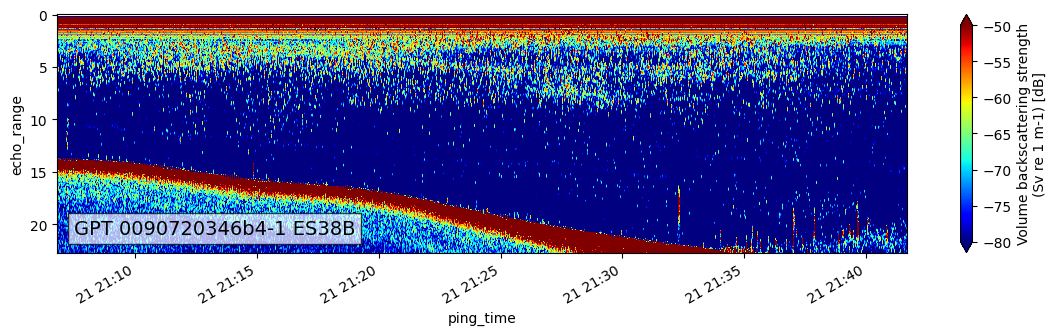

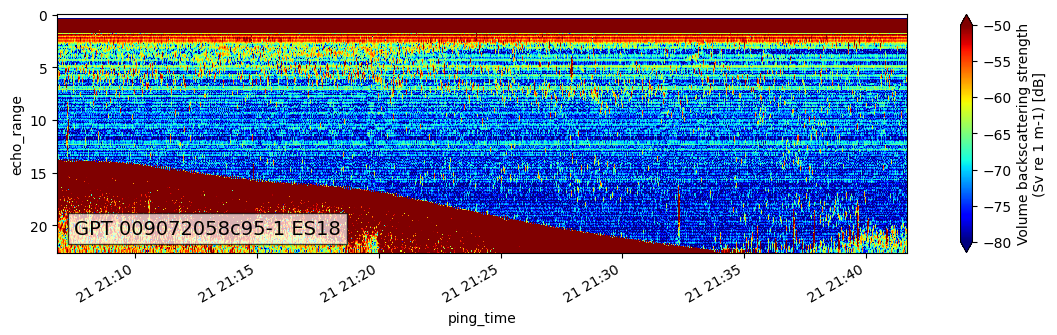

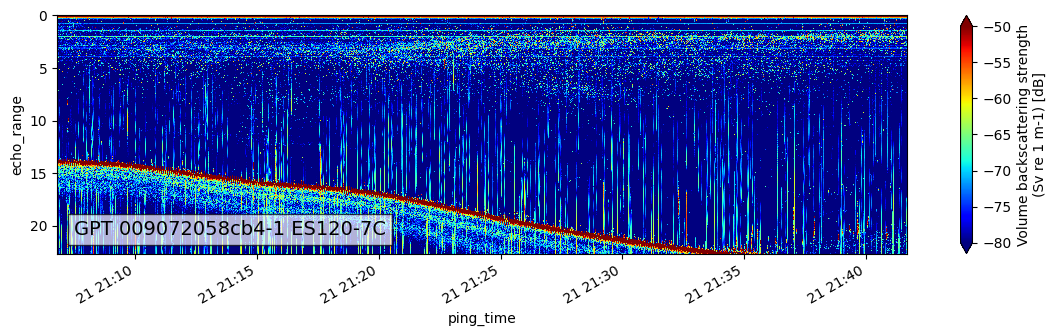

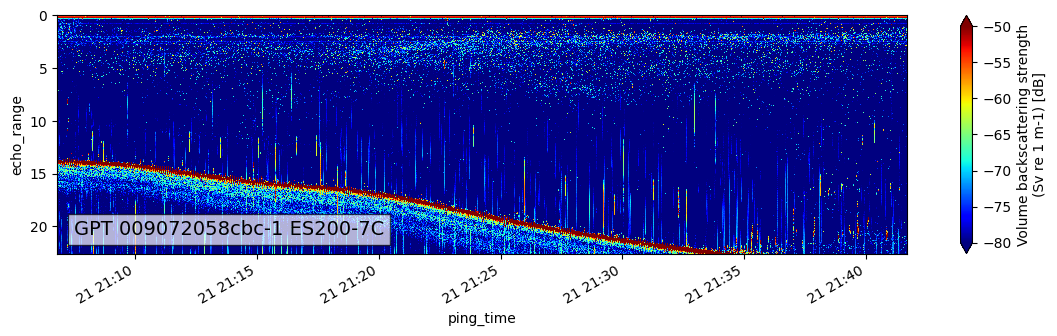

In [18]:
epviz.create_echogram(sv,vmin=-80,vmax=-50)

### Sv dataset extension

In [19]:
%%time

extended_sv = sv_dataset_extension.enrich_sv_dataset(
    sv = sv,
    echodata = ds, 
    waveform_mode="CW",
    encode_mode="power"
)
extended_sv

CPU times: user 9.99 s, sys: 5.99 s, total: 16 s
Wall time: 17 s


<xarray.Dataset>
Dimensions:                        (channel: 4, ping_time: 8954,
                                    range_sample: 3890, filenames: 1)
Coordinates:
  * channel                        (channel) <U27 'GPT 0090720346b4-1 ES38B' ...
  * ping_time                      (ping_time) datetime64[ns] 2019-08-21T21:0...
  * range_sample                   (range_sample) int64 0 1 2 ... 3887 3888 3889
  * filenames                      (filenames) int64 0
Data variables: (12/29)
    Sv                             (channel, ping_time, range_sample) float64 ...
    echo_range                     (channel, ping_time, range_sample) float64 ...
    frequency_nominal              (channel) float64 ...
    sound_speed                    float64 1.51e+03
    sound_absorption               (channel) float64 0.009878 ... 0.05316
    temperature                    float64 10.0
    ...                             ...
    water_level                    float64 ...
    depth                          (channel, ping_time, range_sample) float64 ...
    latitude                       (ping_time) float64 nan nan 30.06 ... nan nan
    longitude                      (ping_time) float64 nan nan ... nan nan
    angle_alongship                (channel, ping_time, range_sample) float64 ...
    angle_athwartship              (channel, ping_time, range_sample) float64 ...
Attributes:
    processing_software_name:     echopype
    processing_software_version:  0.1.dev2337+g364c06a
    processing_time:              2023-11-16T15:08:56Z
    processing_function:          calibrate.compute_Sv
    processing_level:             Level 2A
    processing_level_url:         https://echopype.readthedocs.io/en/stable/p...

In [20]:
%memit extended_sv = sv_dataset_extension.enrich_sv_dataset(sv=sv, echodata=ds, waveform_mode="CW", encode_mode="power")

peak memory: 8739.18 MiB, increment: 2629.22 MiB


### Clearing Memory

In [21]:
del ds
del sv
gc.collect()  # Run the garbage collector to free up memory immediately

780

### Noise masks

- **Compute noise masks and add them as variables to the dataset (using `create_noise_masks_oceanstream` function)**
- Notes:
    - The `create_noise_masks_oceanstream` function is designed to generate noise masks and add them to a specific Sv dataset, utilizing default methods set by the oceanstream team for the foundational operations of oceanstream. This feature can be adjusted based on evaluations with various datasets. Within the mask attributes, the function provides insights into the methods employed for each distinct mask type.

In [22]:
# %%time

# %memit oceanstream_ek80_extended_ds = noise_masks.create_noise_masks_oceanstream(extended_sv)
# oceanstream_ek80_extended_ds

**Important Remarks** 
- Compute noise masks and add them as variables to the dataset using create_noise_masks_oceanstream function is not possible because of the transient mask computation.

**`Impulse` noise mask**

In [23]:
%%time

oceanstream_impulse_mask_param = {"thr": 3, "m": 3, "n": 1}
%memit impulse_mask = noise_masks.create_impulse_mask(extended_sv, parameters=oceanstream_impulse_mask_param, method="ryan")
impulse_mask = add_metadata_to_mask(
    mask=impulse_mask,
    metadata={
        "mask_type": "impulse",
        "method": "ryan",
        "parameters": dict_to_formatted_list(oceanstream_impulse_mask_param),
    },
)

Sv_without_impulse = attach_mask_to_dataset(extended_sv, impulse_mask)
Sv_without_impulse 

peak memory: 6075.30 MiB, increment: 2339.95 MiB
CPU times: user 10.7 s, sys: 5.98 s, total: 16.7 s
Wall time: 18 s


<xarray.Dataset>
Dimensions:                        (channel: 4, ping_time: 8954,
                                    range_sample: 3890, filenames: 1)
Coordinates:
  * channel                        (channel) object 'GPT 0090720346b4-1 ES38B...
  * ping_time                      (ping_time) datetime64[ns] 2019-08-21T21:0...
  * range_sample                   (range_sample) int64 0 1 2 ... 3887 3888 3889
  * filenames                      (filenames) int64 0
Data variables: (12/30)
    Sv                             (channel, ping_time, range_sample) float64 ...
    echo_range                     (channel, ping_time, range_sample) float64 ...
    frequency_nominal              (channel) float64 ...
    sound_speed                    float64 1.51e+03
    sound_absorption               (channel) float64 0.009878 ... 0.05316
    temperature                    float64 10.0
    ...                             ...
    depth                          (channel, ping_time, range_sample) float64 ...
    latitude                       (ping_time) float64 nan nan 30.06 ... nan nan
    longitude                      (ping_time) float64 nan nan ... nan nan
    angle_alongship                (channel, ping_time, range_sample) float64 ...
    angle_athwartship              (channel, ping_time, range_sample) float64 ...
    mask_impulse                   (channel, ping_time, range_sample) bool Fa...
Attributes:
    processing_software_name:     echopype
    processing_software_version:  0.1.dev2337+g364c06a
    processing_time:              2023-11-16T15:08:56Z
    processing_function:          calibrate.compute_Sv
    processing_level:             Level 2A
    processing_level_url:         https://echopype.readthedocs.io/en/stable/p...

**`Attenuation` mask**

In [24]:
%%time

# oceanstream_attenuation_mask_params = {
#         "r0": 180,
#         "r1": 280,
#         "n": 30,
#         "m": None,
#         "thr": -6,
#         "start": 0,
#         "offset": 0,
#     }

oceanstream_attenuation_mask_params = {
    "r0": 180,
    "r1": 280,
    "n": 5,
    "m": None,
    "thr": -5,
    "start": 0,
    "offset": 0,
}

%memit attenuation_mask = noise_masks.create_attenuation_mask(Sv_without_impulse, parameters=oceanstream_attenuation_mask_params, method="ryan")
attenuation_mask = add_metadata_to_mask(
    mask=attenuation_mask,
    metadata={
        "mask_type": "attenuation",
        "method": "ryan",
        "parameters": dict_to_formatted_list(oceanstream_attenuation_mask_params),
    },
)

Sv_without_attenuation = attach_mask_to_dataset(Sv_without_impulse, attenuation_mask)
Sv_without_attenuation 

peak memory: 9430.81 MiB, increment: 4235.66 MiB
CPU times: user 31.4 s, sys: 24.9 s, total: 56.4 s
Wall time: 1min


<xarray.Dataset>
Dimensions:                        (channel: 4, ping_time: 8954,
                                    range_sample: 3890, filenames: 1)
Coordinates:
  * channel                        (channel) object 'GPT 0090720346b4-1 ES38B...
  * ping_time                      (ping_time) datetime64[ns] 2019-08-21T21:0...
  * range_sample                   (range_sample) int64 0 1 2 ... 3887 3888 3889
  * filenames                      (filenames) int64 0
Data variables: (12/31)
    Sv                             (channel, ping_time, range_sample) float64 ...
    echo_range                     (channel, ping_time, range_sample) float64 ...
    frequency_nominal              (channel) float64 ...
    sound_speed                    float64 1.51e+03
    sound_absorption               (channel) float64 0.009878 ... 0.05316
    temperature                    float64 10.0
    ...                             ...
    latitude                       (ping_time) float64 nan nan 30.06 ... nan nan
    longitude                      (ping_time) float64 nan nan ... nan nan
    angle_alongship                (channel, ping_time, range_sample) float64 ...
    angle_athwartship              (channel, ping_time, range_sample) float64 ...
    mask_impulse                   (channel, ping_time, range_sample) bool Fa...
    mask_attenuation               (channel, ping_time, range_sample) bool Fa...
Attributes:
    processing_software_name:     echopype
    processing_software_version:  0.1.dev2337+g364c06a
    processing_time:              2023-11-16T15:08:56Z
    processing_function:          calibrate.compute_Sv
    processing_level:             Level 2A
    processing_level_url:         https://echopype.readthedocs.io/en/stable/p...

In [25]:
oceanstream_ek80_extended_ds = Sv_without_attenuation 

- **Compute `seabed` and `false seabed` masks and add them as variables to the dataset**
- Notes:
   - To effectively utilize the `blackwell_mod` method for seabed detection, ensure that the `Sv` dataset includes the `split-beam angle` parameters. Specifically, the input `Sv` dataset should contain both the `angle_alongship` and `angle_athwartship` variables. The absence of these variables will lead to errors.

In [26]:
%%time

# `blackwell_mod`

BLACKWELL_MOD_DEFAULT_PARAMS = {
    "theta": None,
    "phi": None,
    "r0": 10,
    "r1": 1000,
    "tSv": -75,
    "ttheta": 702,
    "tphi": 282,
    "wtheta": 28,
    "wphi": 52,
    "rlog": None,
    "tpi": None,
    "freq": None,
    "rank": 50,
}
blackwell_mod_mask = noise_masks.create_seabed_mask(
    oceanstream_ek80_extended_ds,
    method="blackwell_mod",
    parameters = BLACKWELL_MOD_DEFAULT_PARAMS,
    )
blackwell_mod_mask = add_metadata_to_mask(
    mask=blackwell_mod_mask , 
    metadata={
        "mask_type": "false_seabed", 
        "method":"blackwell_mod",
        "parameters": dict_to_formatted_list(BLACKWELL_MOD_DEFAULT_PARAMS),
    }
)

oceanstream_ek80_extended_ds = attach_mask_to_dataset(
    oceanstream_ek80_extended_ds, 
    blackwell_mod_mask
)


# `ariza`

ARIZA_PARAMS = {
    "r0": 10,
    "r1": 1000,
    "roff": 0,
    "thr": -35,
    "ec": 15,
    "ek": (1, 3),
    "dc": 150,
    "dk": (1, 3),
}
ariza_mask = noise_masks.create_seabed_mask(
    oceanstream_ek80_extended_ds,
    method="ariza",
    parameters=ARIZA_PARAMS,
)
ariza_mask = add_metadata_to_mask(
    mask=ariza_mask,
    metadata={
        "mask_type": "seabed",
        "method": "ariza",
        "parameters": dict_to_formatted_list(ARIZA_PARAMS),
    },
)

oceanstream_ek80_extended_ds = attach_mask_to_dataset(
    oceanstream_ek80_extended_ds, 
    ariza_mask
)

oceanstream_ek80_extended_ds

/Users/simedroniraluca/Documents/pineview/oceanstream/.venv/lib/python3.9/site-packages/echopype/mask/seabed.py:496: UserWarning: Aliased seabed not detected in Theta & Phi.A default mask with all True values is returned.
  warnings.warn(


CPU times: user 3min 54s, sys: 1min 2s, total: 4min 57s
Wall time: 5min 2s


<xarray.Dataset>
Dimensions:                        (channel: 4, ping_time: 8954,
                                    range_sample: 3890, filenames: 1)
Coordinates:
  * channel                        (channel) object 'GPT 0090720346b4-1 ES38B...
  * ping_time                      (ping_time) datetime64[ns] 2019-08-21T21:0...
  * range_sample                   (range_sample) int64 0 1 2 ... 3887 3888 3889
  * filenames                      (filenames) int64 0
Data variables: (12/33)
    Sv                             (channel, ping_time, range_sample) float64 ...
    echo_range                     (channel, ping_time, range_sample) float64 ...
    frequency_nominal              (channel) float64 ...
    sound_speed                    float64 1.51e+03
    sound_absorption               (channel) float64 0.009878 ... 0.05316
    temperature                    float64 10.0
    ...                             ...
    angle_alongship                (channel, ping_time, range_sample) float64 ...
    angle_athwartship              (channel, ping_time, range_sample) float64 ...
    mask_impulse                   (channel, ping_time, range_sample) bool Fa...
    mask_attenuation               (channel, ping_time, range_sample) bool Fa...
    mask_false_seabed              (channel, ping_time, range_sample) bool Tr...
    mask_seabed                    (channel, ping_time, range_sample) bool Tr...
Attributes:
    processing_software_name:     echopype
    processing_software_version:  0.1.dev2337+g364c06a
    processing_time:              2023-11-16T15:08:56Z
    processing_function:          calibrate.compute_Sv
    processing_level:             Level 2A
    processing_level_url:         https://echopype.readthedocs.io/en/stable/p...

**Proportion of Valid Samples Before Applying masks: (Valid Samples) / (Total Samples)**

In [27]:
oceanstream_ek80_extended_ds["Sv"].count()/oceanstream_ek80_extended_ds["Sv"].size

<xarray.DataArray 'Sv' ()>
array(0.43998711)

### Applying masks

**We will apply only the impulse noise mask and the attenuation mask until the problems caused by the transient noise are resolved.**

(**Applies the following masks to the dataset in the specified order:**

1. `Apply impulse noise mask`

2. `Apply attenuation mask `

3. `Apply transient mask`)

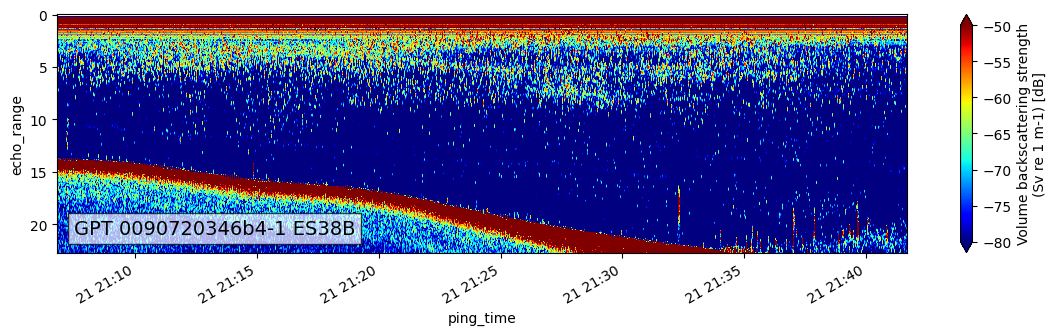

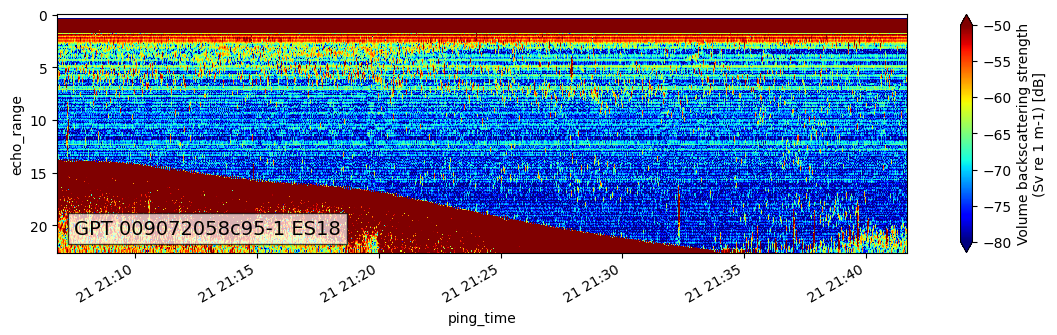

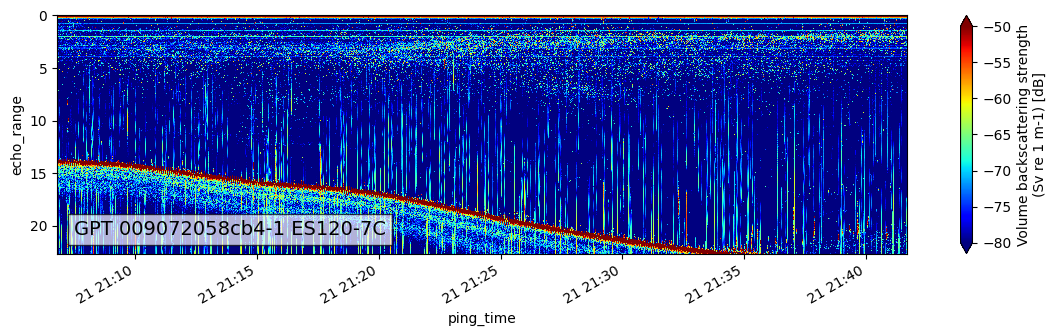

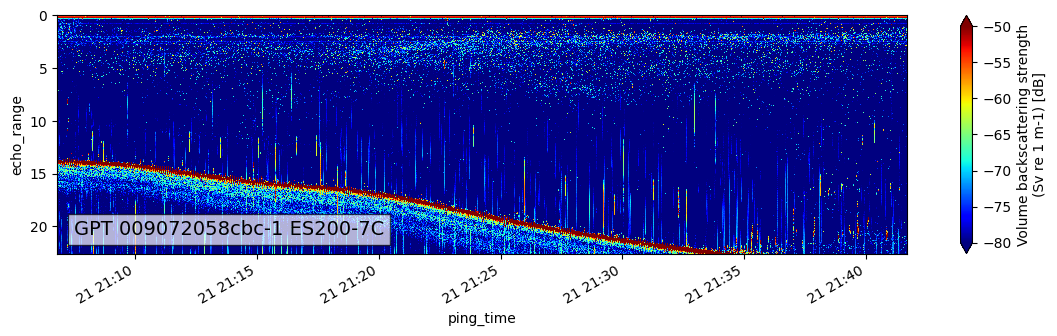

In [28]:
epviz.create_echogram( oceanstream_ek80_extended_ds,vmin=-80,vmax=-50)

CPU times: user 22 s, sys: 7.69 s, total: 29.7 s
Wall time: 30 s


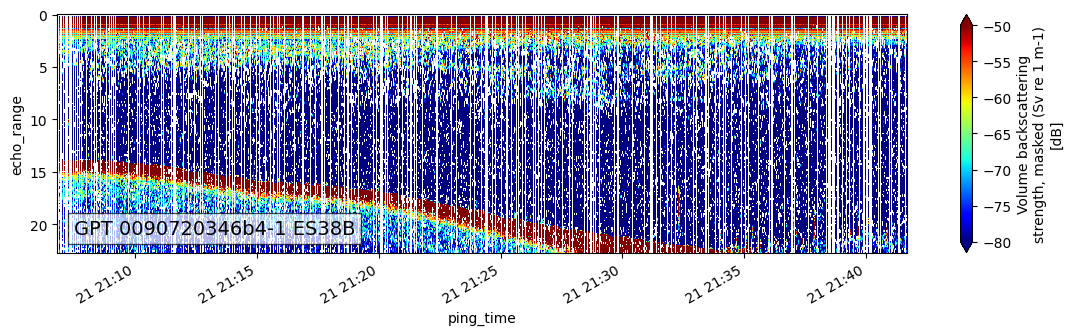

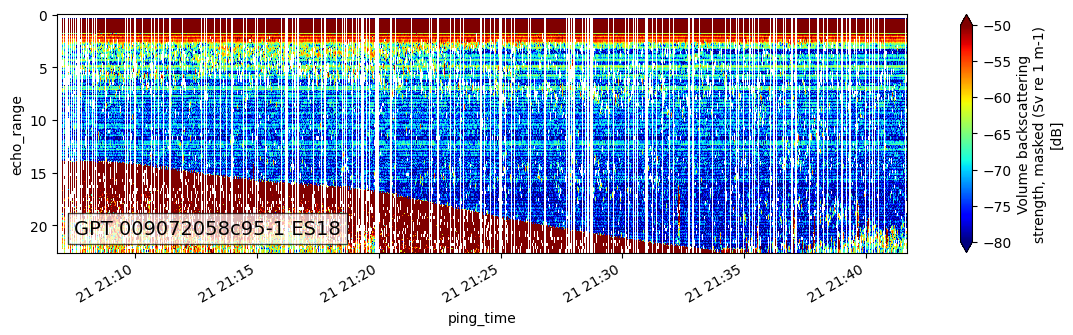

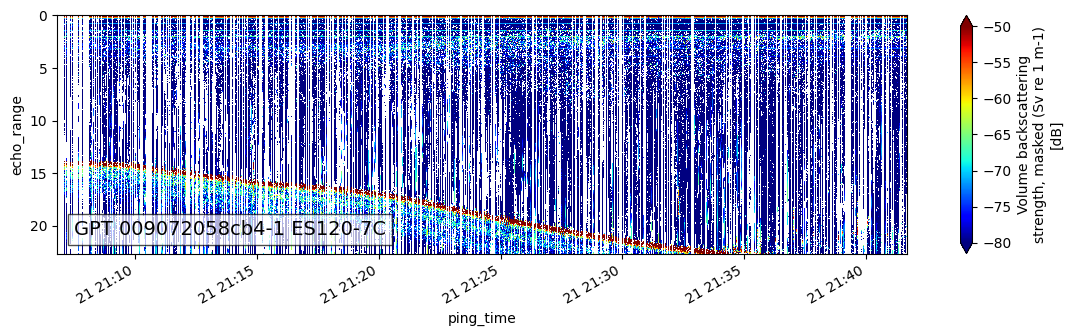

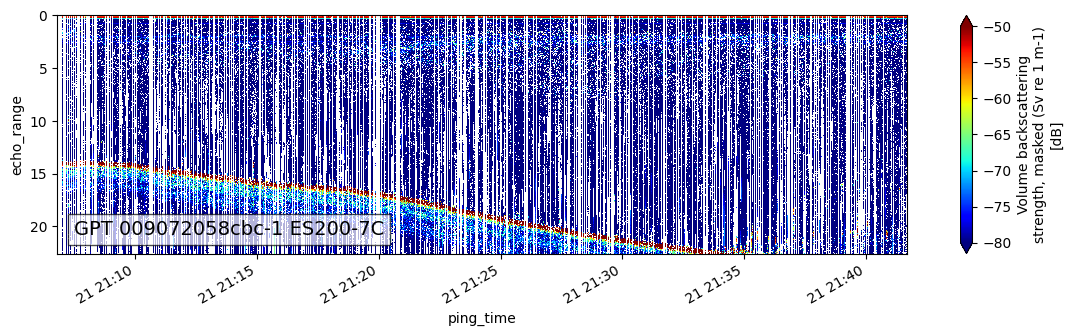

In [29]:
%%time

process_parameters = {
#     "mask_transient": {
#         "var_name": "Sv",
#     },
    "mask_impulse": {
        "var_name": "Sv",
    },
    "mask_attenuation": {
        "var_name": "Sv",
    },
}
cleaned_ds = applying_masks_handler.apply_selected_noise_masks_and_or_noise_removal(
    oceanstream_ek80_extended_ds, 
    process_parameters
)
epviz.create_echogram(cleaned_ds,vmin=-80,vmax=-50)

**Proportion of Valid Samples After Applying masks: (Valid Samples) / (Total Samples)**

In [30]:
cleaned_ds["Sv"].count()/cleaned_ds["Sv"].size

<xarray.DataArray 'Sv' ()>
array(0.2578012)

### Sv interpolation

In [31]:
%%time

interpolated_ds = sv_interpolation.interpolate_sv(cleaned_ds)
interpolated_ds

CPU times: user 9.77 s, sys: 3.55 s, total: 13.3 s
Wall time: 14 s


<xarray.Dataset>
Dimensions:                        (channel: 4, ping_time: 8954,
                                    range_sample: 3890, filenames: 1)
Coordinates:
  * channel                        (channel) <U27 'GPT 0090720346b4-1 ES38B' ...
  * ping_time                      (ping_time) datetime64[ns] 2019-08-21T21:0...
  * range_sample                   (range_sample) int64 0 1 2 ... 3887 3888 3889
  * filenames                      (filenames) int64 0
Data variables: (12/34)
    Sv                             (channel, ping_time, range_sample) float64 ...
    echo_range                     (channel, ping_time, range_sample) float64 ...
    frequency_nominal              (channel) float64 ...
    sound_speed                    float64 1.51e+03
    sound_absorption               (channel) float64 0.009878 ... 0.05316
    temperature                    float64 10.0
    ...                             ...
    angle_athwartship              (channel, ping_time, range_sample) float64 ...
    mask_impulse                   (channel, ping_time, range_sample) bool Fa...
    mask_attenuation               (channel, ping_time, range_sample) bool Fa...
    mask_false_seabed              (channel, ping_time, range_sample) bool Tr...
    mask_seabed                    (channel, ping_time, range_sample) bool Tr...
    Sv_interpolated                (channel, ping_time, range_sample) float64 ...
Attributes:
    processing_software_name:     echopype
    processing_software_version:  0.1.dev2337+g364c06a
    processing_time:              2023-11-16T15:08:56Z
    processing_function:          calibrate.compute_Sv
    processing_level:             Level 3A
    processing_level_url:         https://echopype.readthedocs.io/en/stable/p...
    mask_software_name:           echopype
    mask_software_version:        0.1.dev2337+g364c06a
    mask_time:                    2023-11-16T15:17:49Z
    mask_function:                mask.apply_mask

In [32]:
# Rename Sv to Sv_denoised
# Rename Sv_interpolated to Sv
interpolated_ds = interpolated_ds.rename({"Sv": "Sv_denoised", "Sv_interpolated": "Sv"})

interpolated_ds

<xarray.Dataset>
Dimensions:                        (channel: 4, ping_time: 8954,
                                    range_sample: 3890, filenames: 1)
Coordinates:
  * channel                        (channel) <U27 'GPT 0090720346b4-1 ES38B' ...
  * ping_time                      (ping_time) datetime64[ns] 2019-08-21T21:0...
  * range_sample                   (range_sample) int64 0 1 2 ... 3887 3888 3889
  * filenames                      (filenames) int64 0
Data variables: (12/34)
    Sv_denoised                    (channel, ping_time, range_sample) float64 ...
    echo_range                     (channel, ping_time, range_sample) float64 ...
    frequency_nominal              (channel) float64 ...
    sound_speed                    float64 1.51e+03
    sound_absorption               (channel) float64 0.009878 ... 0.05316
    temperature                    float64 10.0
    ...                             ...
    angle_athwartship              (channel, ping_time, range_sample) float64 ...
    mask_impulse                   (channel, ping_time, range_sample) bool Fa...
    mask_attenuation               (channel, ping_time, range_sample) bool Fa...
    mask_false_seabed              (channel, ping_time, range_sample) bool Tr...
    mask_seabed                    (channel, ping_time, range_sample) bool Tr...
    Sv                             (channel, ping_time, range_sample) float64 ...
Attributes:
    processing_software_name:     echopype
    processing_software_version:  0.1.dev2337+g364c06a
    processing_time:              2023-11-16T15:08:56Z
    processing_function:          calibrate.compute_Sv
    processing_level:             Level 3A
    processing_level_url:         https://echopype.readthedocs.io/en/stable/p...
    mask_software_name:           echopype
    mask_software_version:        0.1.dev2337+g364c06a
    mask_time:                    2023-11-16T15:17:49Z
    mask_function:                mask.apply_mask

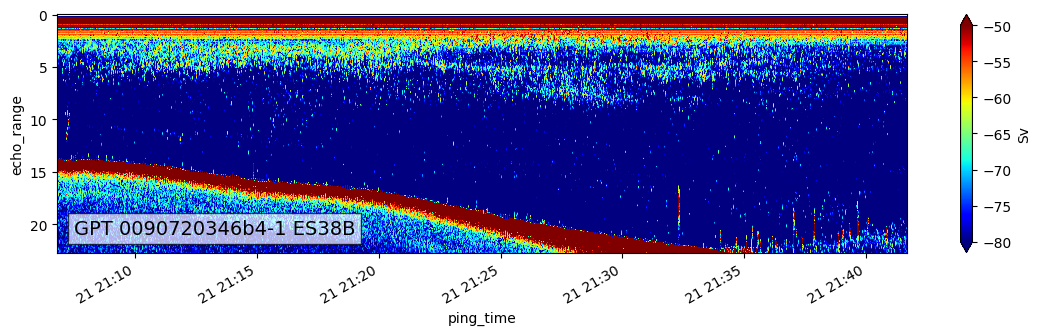

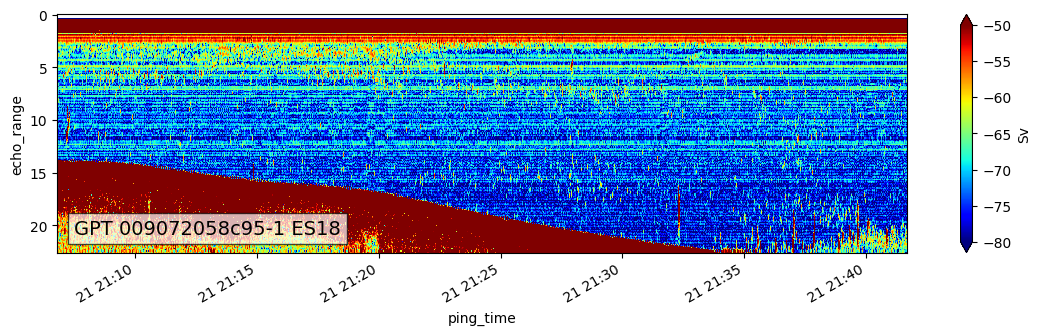

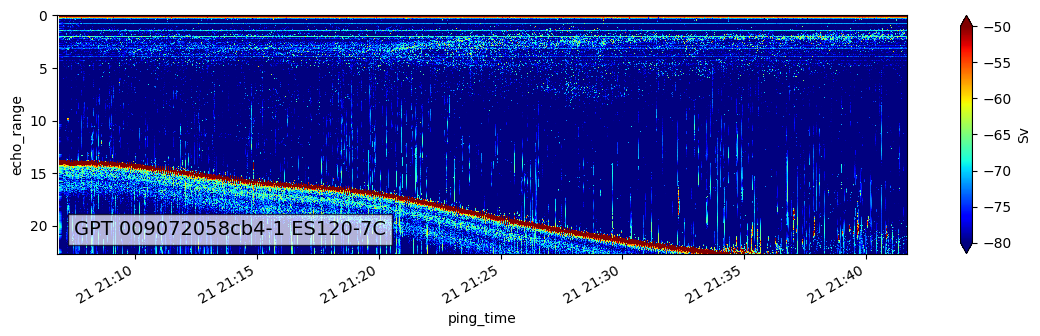

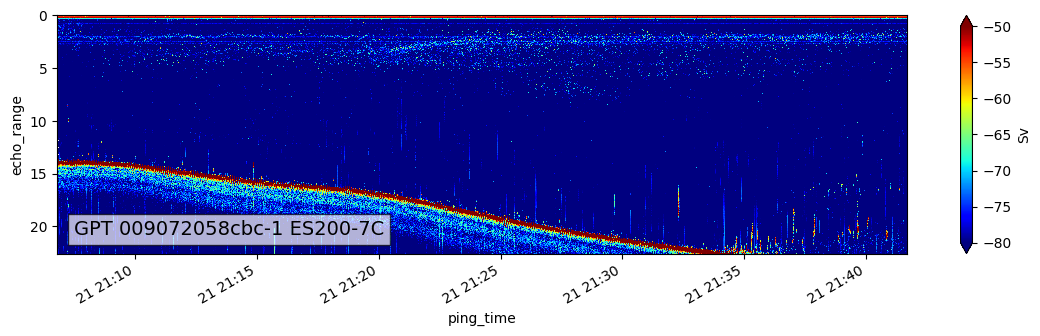

In [33]:
epviz.create_echogram(interpolated_ds,vmin=-80,vmax=-50)

**Proportion of Valid Samples After Interpolation: (Valid Samples) / (Total Samples)**

In [34]:
interpolated_ds["Sv"].count()/interpolated_ds["Sv"].size

<xarray.DataArray 'Sv' ()>
array(0.44051234)

### Remove background noise

In [35]:
%%time

process_parameters = {
        "remove_background_noise": {
        "ping_num": 40,
        #"range_sample_num": 10,
        "noise_max": -125,
        "SNR_threshold": 3,
    },

}
interpolated_ds = applying_masks_handler.apply_selected_noise_masks_and_or_noise_removal(
    interpolated_ds, 
    process_parameters
)



CPU times: user 21.6 s, sys: 21.7 s, total: 43.3 s
Wall time: 46.9 s


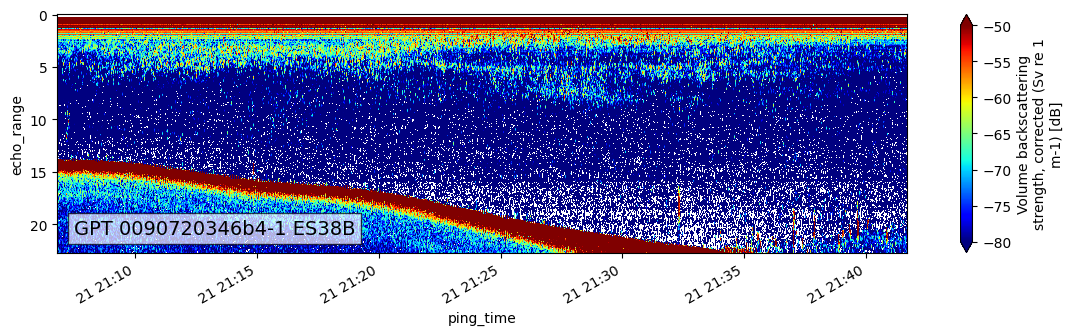

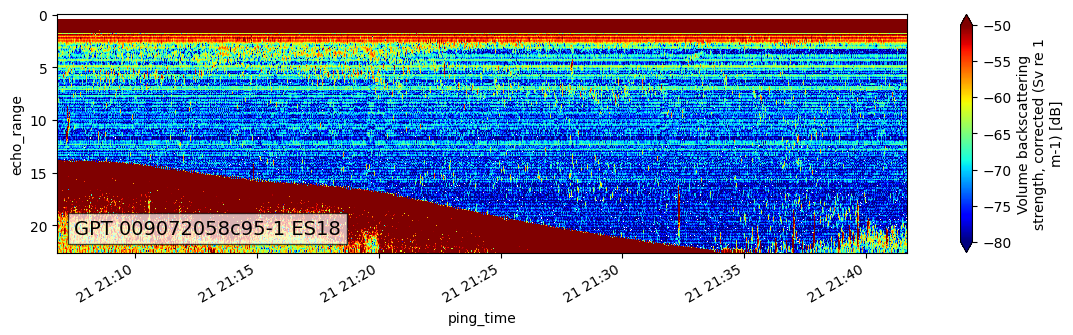

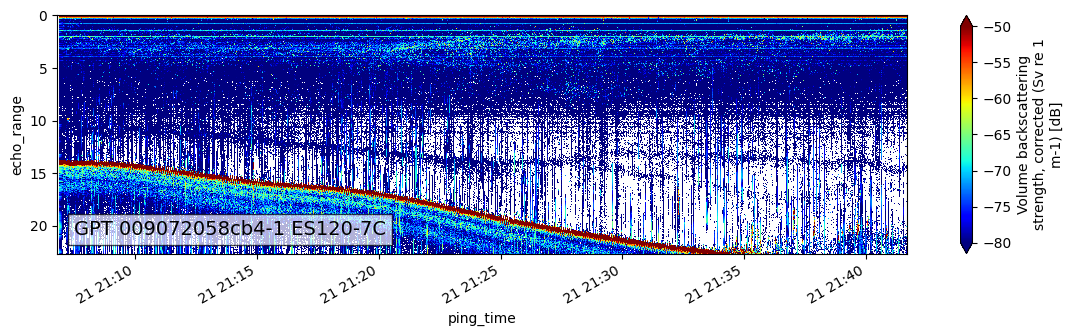

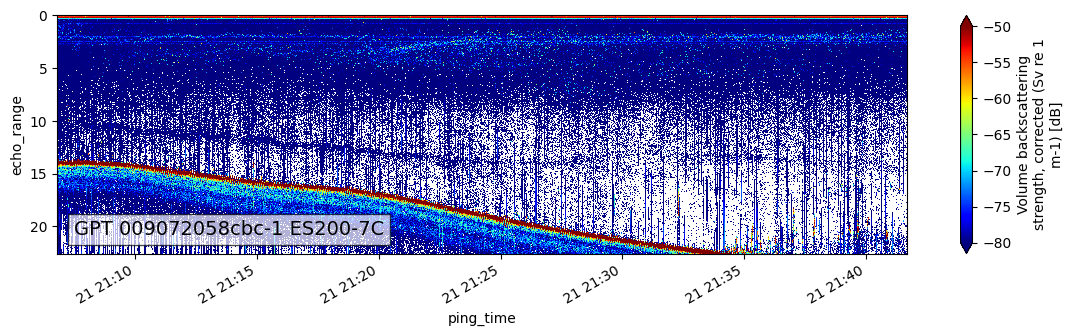

In [36]:
epviz.create_echogram(interpolated_ds,vmin=-80,vmax=-50)

**Proportion of Valid Samples After Background Noise Removal: (Valid Samples) / (Total Samples)**

In [37]:
interpolated_ds["Sv"].count()/interpolated_ds["Sv"].size

<xarray.DataArray 'Sv' ()>
array(0.30699698)

### Apply `seabed` and  `false_seabed` masks

In [ ]:
%%time

process_parameters = {
    'mask_seabed': {
    'var_name': 'Sv',
    },
    'mask_false_seabed': {
    'var_name': 'Sv',
    }
}

interpolated_ds = applying_masks_handler.apply_selected_noise_masks_and_or_noise_removal(
    interpolated_ds, 
    process_parameters
)



In [ ]:
epviz.create_echogram(interpolated_ds,vmin=-80,vmax=-50)

**Proportion of Valid Samples After Applying `seabed` and `false_seabed` masks: (Valid Samples) / (Total Samples)**

In [ ]:
interpolated_ds["Sv"].count()/interpolated_ds["Sv"].size

# Compute general NASC

In [ ]:
%%time

nasc = nasc_computation.compute_per_dataset_nasc(interpolated_ds)
nasc['NASC_dataset']['NASC']

### Compute MVBS

In [ ]:
%%time

interpolated_ds_MVBS = compute_mvbs(
    interpolated_ds, 
    method="physical_units", 
    range_bin="20m", 
    ping_time_bin="20S")
interpolated_ds_MVBS

### Use frequency differencing handler

In [ ]:
%%time

chan120 = 'GPT 120 kHz 00907205a6d0 4-1 ES120-7C'
chan38 = 'GPT  38 kHz 009072058146 2-1 ES38B'
ds_Sv_with_krill_mask = frequency_differencing_handler.identify_krill(interpolated_ds, chan120=chan120, chan38=chan38)


chan120 = 'GPT 120 kHz 00907205a6d0 4-1 ES120-7C'
chan38 = 'GPT  38 kHz 009072058146 2-1 ES38B'
ds_Sv_with_gas_bearing_organisms_mask = frequency_differencing_handler.identify_gas_bearing_organisms(
    ds_Sv_with_krill_mask,
    chan120=chan120,
    chan38=chan38
)


chan120 = 'GPT 120 kHz 00907205a6d0 4-1 ES120-7C'
chan38 = 'GPT  38 kHz 009072058146 2-1 ES38B'
ds_Sv_with_fluid_like_organisms_mask = frequency_differencing_handler.identify_fluid_like_organisms(
    ds_Sv_with_gas_bearing_organisms_mask,
    chan120=chan120,
    chan38=chan38
)





#ds_Sv_with_shoal_combined_mask = shoal_detection_handler.attach_shoal_mask_to_ds(ds_Sv_with_fluid_like_organisms_mask)
#ds_Sv_with_shoal_combined_mask


The shoal detection process is notably time-consuming; on my machine, the computation of the shoal mask took more than 7 hours, prompting me to halt the process due to the excessive duration. That's why we do not compute the shoal_mask here for now until we have an efficient method.

In [ ]:
ds_Sv_with_shoal_combined_mask = ds_Sv_with_fluid_like_organisms_mask 

### Apply `krill` and `shoal` masks

In [ ]:
%%time

process_parameters = {
    'mask_krill': {
        'var_name': 'Sv',
    },
#     'mask_shoal': {
#         'var_name': 'Sv',
#     }
}

organisms_ds = apply_mask_organisms_in_order(ds_Sv_with_shoal_combined_mask, process_parameters)
epviz.create_echogram(organisms_ds,vmin=-80,vmax=-50)

### Compute krill shoal NASC

In [ ]:
%%time

krill_nasc = nasc_computation.compute_per_dataset_nasc(organisms_ds)
krill_nasc['NASC_dataset']['NASC']

### Save the processed dataset

In [ ]:
%%time

os.makedirs(os.path.join(oceanstream_ek80_path, 'test'), exist_ok=True)
processed_data_io.write_processed(
    sv = organisms_ds,
    file_path = os.path.join(oceanstream_ek80_path, 'test'),
    file_name = "test_processed_EK80",
    file_type = "nc",
)

organisms_ds

### Read the saved dataset

In [ ]:
%%time

test_ds = processed_data_io.read_processed(
    file_path=os.path.join(
        oceanstream_ek80_path, 
        'test',
        'test_processed_EK80.nc'
    )
)
test_ds

In [ ]:
epviz.create_echogram(test_ds,vmin=-80,vmax=-50)